<h1>Deep learning project 8DM20 CSMIA</h1>

<h4>Group members:</h4>
O. Akdag - 0842508 <br>
T.P.A. Beishuizen - 0791613 <br>
A.S.A. Eskelinen - 1224333 <br>
J.H.A. Migchielsen - 0495058 <br>
L. van den Wildenberg - 0844697 <br>

In [1]:
# Import all used packages (unused packages are commented out so far)
import os
from PIL import Image as PIL_image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
from sklearn.feature_extraction import image as sklearn_image
#import matplotlib
#matplotlib.use('Agg')
#matplotlib inline
import theano
import lasagne
import time
import random
import math
import cPickle
random.seed(0)

C:\Users\s119104\AppData\Local\Continuum\Anaconda2\lib\site-packages\theano\tensor\signal\downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


<h4>Preprocessing</h4>

Before every thing can be done, at first the data images have to be read and be made in useable data types.

In [2]:
# The function that loads the data
def loadData(data_set = 'test', image = '1st_manual'):
    
    # Check for the correct input
    if data_set != 'test' and data_set != 'training':
        raise Exception('Not the right data_set file')
    if image != '1st_manual' and image != '2nd_manual' and image != 'images' and image != 'mask':
        raise Exception('Not the right image file')
    if data_set == 'training' and image == '2nd_manual':
        raise Exception('File not available')
    
    # Project and image path
    project_path = os.getcwd()
    images_path = project_path +  '/8DM20_image_dataset/' + data_set + '/' + image + '/'
    
    images = []
    
    #Open image for image (20 in total for each of them)
    for i in range(1, 21):
        
        # Find correct image number
        image_nr = str(i)
        if data_set == 'training':
            image_nr = str(20 + i)
        elif len(image_nr) == 1:
            image_nr = '0' + image_nr
            
        # Specify path for this image
        if image == '1st_manual':
            image_path = images_path + image_nr + '_manual1.gif'
        elif image == '2nd_manual':
            image_path = images_path + image_nr + '_manual2.gif'
        elif image == 'images':
            image_path = images_path + image_nr + '_' + data_set + '.tif'
        elif image == 'mask':
            image_path = images_path + image_nr + '_' + data_set + '_mask.gif'
        
        # Open and append the image to the image list
        images.append(PIL_image.open(image_path))
        
    return images

#The function that converts the channels in the images from RGB to gray
#and makes matrices from the images
def convertImageToMatrix(images):
    
    image_matrices = []
    
    for image in images:
        image_matrix = np.asarray(image.convert('RGB'))
        green_image_matrix = image_matrix[:,:,1]
        image_matrices.append(green_image_matrix)
        
    return image_matrices

#The function that prepares the image matrices to the data used for machine learning
def prepareMachineLearningData(image_matrix, output_matrix, mask_matrix, kernel_size, mask_removal = 'pixel'):
    #Check if correct input
    if not (isinstance(image_matrix, np.ndarray) and 
            isinstance(output_matrix, np.ndarray) and 
            isinstance(mask_matrix, np.ndarray)):
        raise Exception("Not all input matrices are numpy matrices")
    
    if mask_removal != 'pixel' and mask_removal != 'patch':
        raise Exception("Unknown mask data removal type")
    
    if not (image_matrix.shape == output_matrix.shape == mask_matrix.shape):
        raise Exception("The images are not the same size")
    
    if np.unique(mask_matrix).shape[0] != 2:
        raise Exception("The mask matrix does not consist of only 2 values")
    
    # Matrix reduction
    mat_red = kernel_size / 2
    
    # Makes some additional mask values zero on the edge of the mask
    new_mask_matrix = mask_matrix.copy()
    
    image_patches = []
    output_array = []
    
    # Remove patch pixels with masks
    if mask_removal == 'patch':
        for i in range(mat_red - 1, mask_matrix.shape[0] - mat_red):
            for j in range(mat_red - 1, mask_matrix.shape[1] - mat_red):
                if 0 in mask_matrix[i - mat_red + 1: i + mat_red + 1, j - mat_red + 1: j + mat_red + 1]:
                    new_mask_matrix[i,j] = 0;
    
    # Append the patches append the output
    for i in range(mat_red - 1, mask_matrix.shape[0] - mat_red):
        for j in range(mat_red - 1, mask_matrix.shape[1] - mat_red):
            if new_mask_matrix[i][j] > 0:
                image_patches.append(image_matrix[i - mat_red + 1: i + mat_red + 1, j - mat_red + 1: j + mat_red + 1])
                output_array.append(output_matrix[i][j])
    
    # Make the image have the right dimensions
    corr_image_patches = np.expand_dims(image_patches, axis=1)
    
    return corr_image_patches, output_array

# Prepare multiple images at once
def prepareMultipleImages(image_matrices, output_matrices, mask_matrices, kernel_size = 25, mask_removal = 'pixel'):
    #Check if correct input
    if not (isinstance(image_matrices, list) and 
            isinstance(output_matrices, list) and 
            isinstance(mask_matrices, list)):
        raise Exception("Not all input matrices are numpy matrices")
    
    if not (len(image_matrices) == len(output_matrices) == len(mask_matrices)):
        raise Exception("The images are not the same size")
    
    image_patches = [] 
    output_arrays = []
    
    # Finds the output data per image
    for i in range(len(image_matrices)):
        new_image_patches, new_output_array = prepareMachineLearningData(image_matrices[i], output_matrices[i], mask_matrices[i], 
                                                                         kernel_size = kernel_size, mask_removal = mask_removal)
        image_patches.append(new_image_patches)
        output_arrays.append(new_output_array)
        
        #Print progress for showing time consumption
        print"Progress: {} %".format(100*(i+1)/len(image_matrices)),
              
    return image_patches, output_arrays

def createVesselImage(output_array, mask_matrix, kernel_size, mask_removal = "pixel"):
    #Check if input is correct
    if not isinstance(output_array, list) or not isinstance(mask_matrix, np.ndarray) or not isinstance(kernel_size, int):
        raise Exception("Not the right input variables")
    
    if mask_removal != "pixel" and mask_removal != 'patch':
        raise Exception("Unknown mask removal type")
    
    #Create an output_matrix for the output array
    #output_matrix = np.array(mask_matrix)
    output_matrix = np.zeros(mask_matrix.shape)
    output_loc = 0
    
    # Take into account that mask pixels too close to the border are lost due to inability to make patches
    edge_corr = int(math.ceil(kernel_size / 2) - 1)
    
    new_mask_matrix = mask_matrix.copy()
    
    # Makes some additional mask values zero on the edge of the mask
    if mask_removal == 'patch':
        for i in range(edge_corr, mask_matrix.shape[0] - edge_corr - 2):
            for j in range(edge_corr, mask_matrix.shape[1] - edge_corr - 2):
                if 0 in mask_matrix[i - edge_corr  : i + edge_corr + 2, j - edge_corr: j + edge_corr + 2]:
                    new_mask_matrix[i,j] = 0;
       
    # Check every pixel within the mask for a vessel pixel
    for i in range(mask_matrix.shape[0] - kernel_size + 1):
        for j in range(mask_matrix.shape[1] - kernel_size + 1):
            if new_mask_matrix[i + edge_corr, j + edge_corr] == 255:
                output_matrix[i + edge_corr, j + edge_corr] = output_array[output_loc]
                output_loc += 1
                
    return output_matrix 

def train_and_validation_set(image_patches, output_array):
    all_train_patches = []
    all_train_output = []
    
    # Make an array with the patches and the last one is the validation image
    for i in range(nr_images_training - 1):
        for j in range(len(image_patches[i])):
            all_train_patches.append(image_patches[i][j])
            all_train_output.append(output_array[i][j])

    valid_patches = image_patches[nr_images_training - 1]
    valid_output = output_array[nr_images_training - 1]
    
    return all_train_patches, all_train_output, valid_patches, valid_output

All images are loaded and immediately made into matrices for further computation

In [3]:
# All test image lists
test_manual1_images = loadData('test', '1st_manual')
test_manual2_images = loadData('test', '2nd_manual')
test_raw_images = loadData('test', 'images')
test_mask_images = loadData('test', 'mask')

# Making matrices of the test images to work with
test_manual1_matrices = convertImageToMatrix(test_manual1_images)
test_manual2_matrices = convertImageToMatrix(test_manual2_images)
test_raw_matrices = convertImageToMatrix(test_raw_images)
test_mask_matrices = convertImageToMatrix(test_mask_images)

# All training image lists
training_manual1_images = loadData('training', '1st_manual')
training_raw_images = loadData('training', 'images')
training_mask_images = loadData('training', 'mask')

# Making matrices of the training images to work with
training_manual1_matrices = convertImageToMatrix(training_manual1_images)
training_raw_matrices = convertImageToMatrix(training_raw_images)
training_mask_matrices = convertImageToMatrix(training_mask_images)

The matrices are then used for further preprocessing to retrieve the suitable data for machine learning

In [5]:
#Choose the number of images
nr_images_training = 20
nr_images_test = 1

# Prepares the data for machine learning: X = image_patches, y = output_array
# Both are a list with the patches and output_arrays for multiple images (the number chosen before)
image_patches, output_array = prepareMultipleImages(training_raw_matrices[0:nr_images_training], training_manual1_matrices[0:nr_images_training], 
                training_mask_matrices[0:nr_images_training], 32, mask_removal = 'patch')
test_image_patches, test_output_array = prepareMultipleImages(test_raw_matrices[0:nr_images_test], test_manual1_matrices[0:nr_images_test], 
                                                     test_mask_matrices[0:nr_images_test], 32, mask_removal = 'patch')


#Divde patches and output in training and validation images
all_train_patches, all_train_output, valid_patches, valid_output = train_and_validation_set(image_patches, output_array)

Progress: 50 % Progress: 100 % Progress: 100 %


<h4>Algorithm setup</h4>
Build the LeNet network

In [6]:
def buildLeNet(X1):
    inputlayer = lasagne.layers.InputLayer(shape=(None, 1, 32, 32),input_var=X1)    
    print inputlayer.output_shape
    
    layer1 = lasagne.layers.Conv2DLayer(inputlayer, num_filters=6, filter_size=(5,5), nonlinearity=lasagne.nonlinearities.rectify, W=lasagne.init.GlorotUniform())
    print layer1.output_shape 
    
    layer2 = lasagne.layers.MaxPool2DLayer(layer1, pool_size=(2, 2))
    print layer2.output_shape 
    
    layer3 = lasagne.layers.Conv2DLayer(layer2, num_filters=16, filter_size=(5,5), nonlinearity=lasagne.nonlinearities.rectify, W=lasagne.init.GlorotUniform())
    print layer3.output_shape 
    
    layer4 = lasagne.layers.MaxPool2DLayer(layer3, pool_size=(2, 2))
    print layer4.output_shape 
    
    layer4 = lasagne.layers.flatten(layer4)
    print layer4.output_shape 
    
    layer5 = lasagne.layers.DenseLayer(layer4,num_units=120,nonlinearity=lasagne.nonlinearities.rectify)    
    print layer5.output_shape 
    
    layer6 = lasagne.layers.DenseLayer(layer5,num_units=84,nonlinearity=lasagne.nonlinearities.rectify)
    print layer6.output_shape 
    
    outputlayer = lasagne.layers.DenseLayer(layer6,num_units=2,nonlinearity=lasagne.nonlinearities.softmax)     
    print outputlayer.output_shape 
    
    return layer1, layer2, layer3, layer4, layer5, layer6, outputlayer

Defining functions for training, validation and testing purposes for the previously made LeNet network

In [7]:
X = theano.tensor.tensor4()
Y = theano.tensor.matrix()
layer1, layer2, layer3, layer4, layer5, layer6, outputlayer = buildLeNet(X)

outputtrain = lasagne.layers.get_output(outputlayer) #function that gets the output from the network defined before.
trainloss = lasagne.objectives.categorical_crossentropy(outputtrain, Y).mean() #function that computes the mean crossentropy between the output and the real labels.
params = lasagne.layers.get_all_params(outputlayer, trainable=True) #function that gets all the parameters (weights) in the network.
updates = lasagne.updates.adam(trainloss, params, learning_rate=0.001) #function that performs an update of the weights based on the loss.
train = theano.function(inputs=[X, Y], outputs=trainloss, updates=updates, allow_input_downcast=True) #function that does all the above based on training samples X and real labels Y.

validate = theano.function(inputs=[X, Y], outputs=trainloss, allow_input_downcast=True) #function that computes the loss without performing an update

outputtest = lasagne.layers.get_output(outputlayer, deterministic=True) #function that gets the output from the network defined before.
test = theano.function(inputs=[X], outputs=outputtest, allow_input_downcast=True) #function that gets the output based on input X

(None, 1, 32, 32)
(None, 6, 28, 28)
(None, 6, 14, 14)
(None, 16, 10, 10)
(None, 16, 5, 5)
(None, 400)
(None, 120)
(None, 84)
(None, 2)


In [9]:
def training_the_network(all_train_output, valid_output, all_train_patches, valid_patches, minibatches = 250, minibatchsize = 100):

    #Recieve vessel and non-vessel patches
    train_non_vessel_patches = []
    train_vessel_patches = []
    
    #First create two training lists. One with vessel patches and one without
    for i in range(len(all_train_output)):
        if all_train_output[i] == 0:
            train_non_vessel_patches.append(all_train_patches[i])          
        else:
            train_vessel_patches.append(all_train_patches[i])
    
    valid_non_vessel_patches = []
    valid_vessel_patches = []
    
    #Second create two valid lists. One with vessel patches and one without
    for i in range(len(valid_output)):
        if valid_output[i] == 0:
            valid_non_vessel_patches.append(valid_patches[i])          
        else:
            valid_vessel_patches.append(valid_patches[i])
    
    #Create, train and validate the patches
    t0 = time.time()
    losslist = []
    validlosslist = []
    
    for i in xrange(minibatches):

        # Random train sample information. IMPORTANT: Use the hot encoded labels (that's the way the algorithm works)
        random_train_patches, random_train_output = sampleBatches(train_non_vessel_patches, train_vessel_patches, 
                                                                  batch_size = minibatchsize, distribution = 0.5)

        #print("image without vessels: %d" % (random_train_output[0][0]))
        #plt.imshow(random_train_patches[0][0])
        #plt.show()
        #print("image with vessels: %d" % (random_train_output[minibatchsize-1][1]))
        #plt.imshow(random_train_patches[minibatchsize-1][0])
        #plt.show()
        
        # Random validation sample information IMPORTANT: Use the hot encoded labels (that's the way the algorithm works)
        random_valid_patches, random_valid_output = sampleBatches(valid_non_vessel_patches, valid_vessel_patches,
                                                                  batch_size = minibatchsize, distribution = 0.5)

        new_train_loss = train(random_train_patches, random_train_output)
        losslist.append(new_train_loss)

        new_valid_loss = validate(random_valid_patches, random_valid_output)
        validlosslist.append(new_valid_loss)
        #select random training en validation samples and perform training and validation steps here.
        
        
        print("Currently at batch %d, has loss of %0.2f and validloss of %0.2f " % (i, new_train_loss, new_valid_loss))
        #print(test(all_train_patches[105:106]))
        #print(test(all_train_patches[80700:80701]))
        
        
    t1 = time.time()
    print 'Training time: {} seconds'.format(t1-t0)
    
    return losslist, validlosslist


# Creates batches of vessel and non vessel images of a certain distribution
def sampleBatches(non_vessel_patches, vessel_patches, batch_size = 100, distribution = 0.5):
  
    if distribution < 0 or distribution > 1:
        raise Exception("Impossible distribution")
            
    # Choose non vessel patches for in the batch
    samples_non_vessel = np.arange(len(non_vessel_patches)) #numbers from 0 until the number of samples
    random_non_vessel_samples = random.sample(samples_non_vessel, int(batch_size * distribution))
    batch_non_vessel_output = int(batch_size * distribution) * [[1, 0]]
    batch_non_vessel_patches = np.asarray(non_vessel_patches)[random_non_vessel_samples]
    
    # Choose vessel patches for in the batch
    samples_vessel = np.arange(len(vessel_patches)) #numbers from 0 until the number of samples
    random_vessel_samples = random.sample(samples_vessel, int(batch_size * (1 - distribution)))
    batch_vessel_output = int(batch_size * (1 - distribution)) * [[0, 1]]
    batch_vessel_patches = np.asarray(vessel_patches)[random_vessel_samples]
             
    # Combine the batches    
    batch_patches = np.append(batch_non_vessel_patches, batch_vessel_patches, axis = 0)
    batch_output = np.append(batch_non_vessel_output, batch_vessel_output, axis = 0)
                                          
    return batch_patches, batch_output

image without vessels: 1


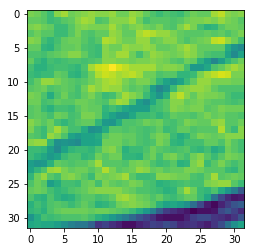

image with vessels: 1


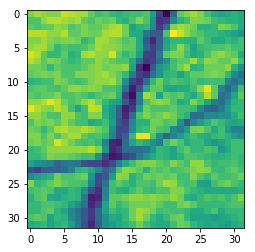

Currently at batch 0, has loss of 8.39 and validloss of 21.02 
image without vessels: 1


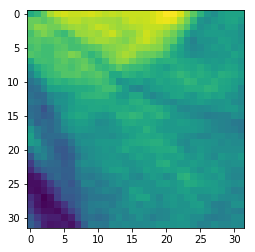

image with vessels: 1


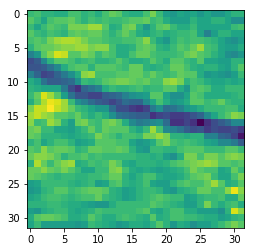

Currently at batch 1, has loss of 22.82 and validloss of 1.28 
image without vessels: 1


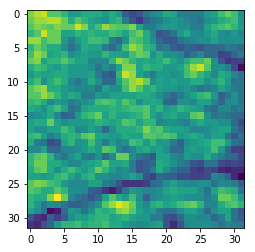

image with vessels: 1


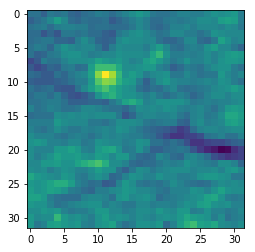

Currently at batch 2, has loss of 1.12 and validloss of 0.69 
image without vessels: 1


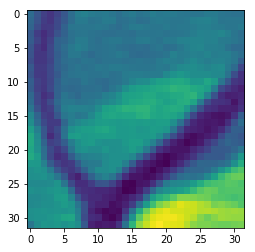

image with vessels: 1


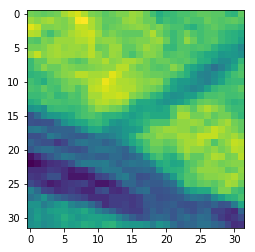

Currently at batch 3, has loss of 0.92 and validloss of 0.69 
image without vessels: 1


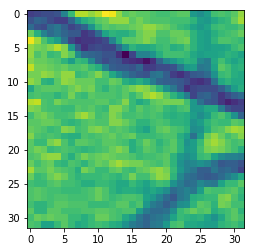

image with vessels: 1


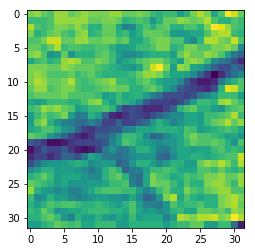

Currently at batch 4, has loss of 0.69 and validloss of 0.69 
image without vessels: 1


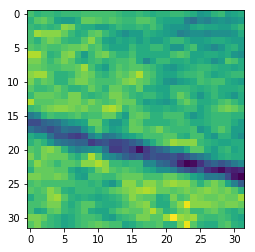

image with vessels: 1


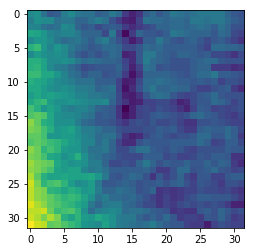

Currently at batch 5, has loss of 0.69 and validloss of 0.69 
image without vessels: 1


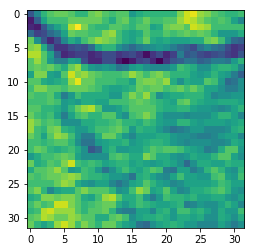

image with vessels: 1


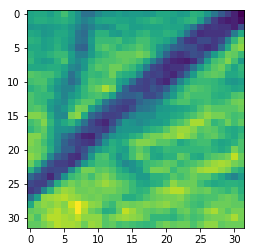

Currently at batch 6, has loss of 0.69 and validloss of 0.69 
image without vessels: 1


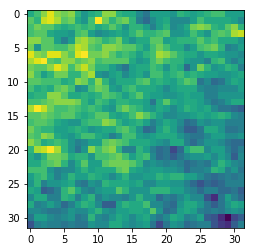

image with vessels: 1


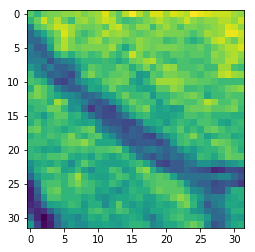

Currently at batch 7, has loss of 0.69 and validloss of 0.69 
image without vessels: 1


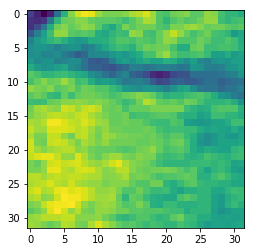

image with vessels: 1


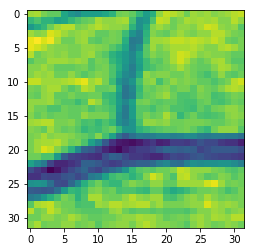

Currently at batch 8, has loss of 0.69 and validloss of 0.69 
image without vessels: 1


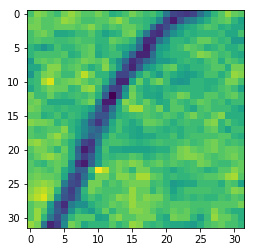

image with vessels: 1


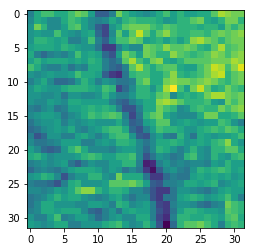

Currently at batch 9, has loss of 0.69 and validloss of 0.69 
Training time: 21.3389999866 seconds


In [10]:
minibatches = 1000
minibatchsize = 200
losslist, validlosslist = training_the_network(all_train_output, valid_output, all_train_patches, valid_patches, minibatches, minibatchsize)

<h4> Testing algorithm</h4>
Test the algorithm with putting in an image_patch and checking if the result is correct.

In [2]:
#t0 = time.time()

#test_results = []
#for i in range(nr_images_test):
#    test_image_predictions = []
#    for j in range(0,len(test_image_patches[i]), 500):
#        if j + 500 >= len(test_image_patches[i]):
#            testing = test(test_image_patches[i][j:j+len(test_image_patches[i])])
#        else:
#            testing = test(test_image_patches[i][j:j+500])
#        
#        test_set_predictions = np.argmax(testing, axis = 1)
#        test_image_predictions.extend(test_set_predictions)
#    
#    test_results.append(test_image_predictions)
#    print("Currently at image %d" % i)
#    print("Fraction of vessel pixels %d" % sum(test_image_predictions)/len(test_image_predictions))
#
#
#t1 = time.time()
#print 'Testing time: {} seconds'.format(t1-t0)
#

In [30]:
def save_weights(filename,network):
    with open(filename, 'wb') as f:
        cPickle.dump(lasagne.layers.get_all_param_values(network), f)
        cPickle.dump(losslist, f)
        cPickle.dump(validlosslist, f)
        cPickle.dump(test_results, f)
        
def load_weights(filename, network):
    with open(filename, 'rb') as f:
        lasagne.layers.set_all_param_values(network, cPickle.load(f))

project_path = os.getcwd()
filename = project_path + '/Project1_weights.pkl' #'C:/Users/Atte/Desktop/Capita selecta/8DM20-CSMIA-group-3/Project/Project1_weights.pkl' 
network = outputlayer
save_weights(filename, network)
print("Saved weights")

Saved weights
